# <center> Code - Engineer Internship 2019/2020 -
## <center> Flame Detection & Localization based on Temporal Approach
## <center> Part 1/2 : Base model
 
##### Work done by : Siwar Mhadhbi

---
# <center> Importations
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from pathlib import Path
import xml.etree.ElementTree as ET
import cv2

---
# <center>  Data preparation
---


In [ ]:
# Set some parameters
im_width = 224     # 128
im_height = 224    # 128
border = 5

In [ ]:
path='/content/drive/My Drive/EngineerInternship-Flamedetection/tgs_trainData/images'
path_mask='/content/drive/My Drive/EngineerInternship-Flamedetection/tgs_trainData/masks'
ids = next(os.walk(path))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load images and masks (ground truth) into arrays

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(path+'/'+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(path_mask+"/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [ ]:
for n in range(len(y)):
  y[n]=y[n]/np.max()

In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
            
def mysplit(s):
  head = s.rstrip('0123456789')
  tail = s[len(head):]
  return head, tail

def create_mask(bb, rows,cols):
    """Creates a mask for the bounding box of same shape as image"""
    Y = np.zeros((rows,cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[1],x[0],x[3],x[2]])

In [ ]:
# ******************** Run only for loading : time spent 4 hours  *************************

IMG_SIZE=224

optFlow_path= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/optflow_train/train'                 ##############
anno_path= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_train/all annotations/annotations the rest for 1st step'              ##############

annotations = filelist(anno_path, '.xml')
data = []
classe=0
for anno_path in tqdm_notebook(annotations):
    # ***** import FLOW_IMAGE
    root = ET.parse(anno_path).getroot() 
    ch=root.find("./filename").text
    L=ch.split('.')
    ext=Path(str(optFlow_path) + '/'+mysplit(L[0])[0]+'_optflow_'+ mysplit(L[0])[1]+'.png')
    if (os.path.isfile(str(ext))):
      #print('optFlw exist : ',mysplit(L[0])[0]+'_optflow_'+ mysplit(L[0])[1]+'.png')
      img = cv2.imread(str(ext)) ###### modify the path
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (im_width, im_height),3) #optical flow images are already resized anyways

      # ***** import annotations : B_BOX
      root = ET.parse(anno_path).getroot()
      exist=root.find("./object/bndbox/xmin")
      #print(exist)
      if exist is None: ######### *********************************************************************
        #print('exist is none')
        classe=0
        bb = create_bb_array([0,0,0,0])
        bb_mask_resized = cv2.resize(create_mask(bb,400,500), (im_width, im_height)) 
        bb_mask_resized = cv2.resize(bb_mask_resized, (im_width, im_height),1)
      else :
        classe=1
        x0=int(exist.text)
        y0=int(root.find("./object/bndbox/ymin").text)
        x1=int(root.find("./object/bndbox/xmax").text)
        y1=int(root.find("./object/bndbox/ymax").text)
        bb = create_bb_array([x0,y0,x1,y1])
        bb_mask_resized = cv2.resize(create_mask(bb,400,500), (im_width, im_height)) 
        bb_mask_resized = cv2.resize(bb_mask_resized, (im_width, im_height),1)

      # ***** Create Data
      data.append([img,bb_mask_resized,classe])



########    shuffle data
random.shuffle(data) 
print(len(data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



6332


#### Associate images with ground truth

In [ ]:
X=[i[0] for i in data]
y=[i[1] for i in data]
class_true=[i[2] for i in data]

X=np.array(X)
y=np.array(y)


#### Check non-fire images

In [ ]:
cnt=0
for i in class_true:
  if i==0:
    cnt=cnt+1
    
print ('<no fire> : ',cnt)

<no fire> :  325


---
# <center> Preprocessing
---

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#### Visualize example image and corresponding mask at random

Text(0.5, 1.0, 'Flame Position')

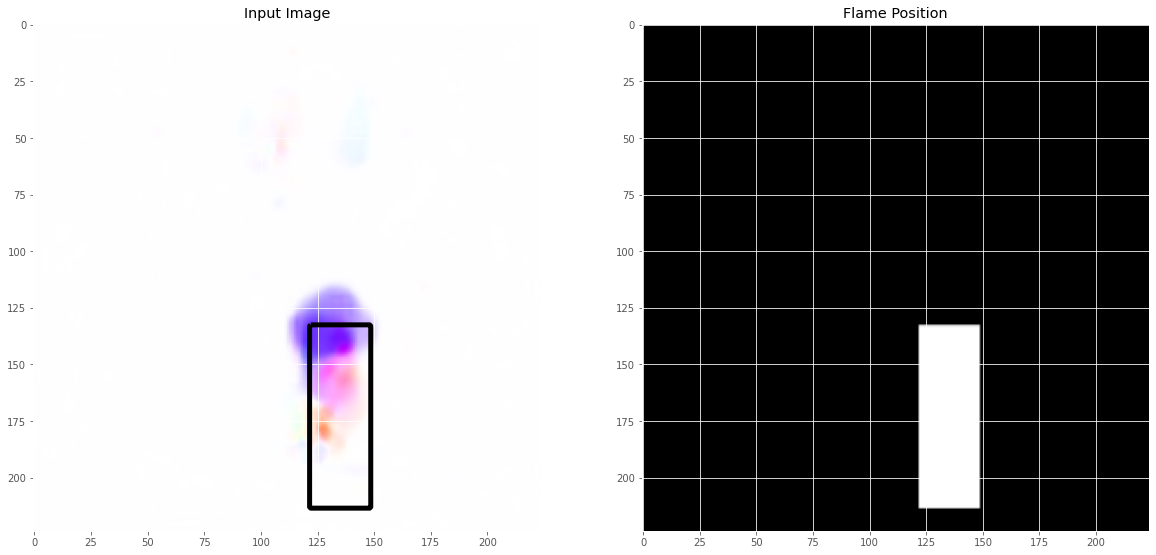

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix])
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Input Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Flame Position')

---
# <center> Modeling
---

#### Define Architecture from scratch

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x) #######################################
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')                ####### was 1
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

#### Summary of the model

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

---
# <center> Training
---

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
#### Time spent : around 6 hours
results = model.fit(X_train, y_train, 
                    batch_size=16, epochs=20, callbacks=callbacks,   #16 ,, 5
                    validation_data=(X_valid, y_valid))

---
# <center> Quantitative Results
---

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.subplot(122)
plt.plot(results.history['accuracy'], label='Train')
plt.plot(results.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True);
plt.legend()

plt.show()

In [ ]:
# load the best model
model.load_weights('model.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

24/24 [==============================] - 50s 2s/step - loss: 0.1096 - accuracy: 0.9574


[0.10961521416902542, 0.9573571681976318]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

12/12 [==============================] - 46s 4s/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

---
# <center> Qualitative Results
---

### Predictions on **training** set

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])#################, cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(),cmap = 'gray', interpolation = 'bilinear')
    ax[0].set_title('Input Image')


    ax[1].imshow(y[ix].squeeze(),cmap = 'gray', interpolation = 'bilinear')
    ax[1].set_title('Flame Position')


    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1,cmap = 'gray', interpolation = 'bilinear')
    if has_mask:
        ax[2].contour(y[ix].squeeze(),cmap = 'gray', interpolation = 'bilinear')
    ax[2].set_title('Flame Position Predicted')
    

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap = 'gray', interpolation = 'bilinear')
    if has_mask:
        ax[3].contour(y[ix].squeeze(),cmap = 'gray', interpolation = 'bilinear')
    ax[3].set_title('Binary Flame Position Predicted');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'interpolation'
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'interpolation'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'interpolation'


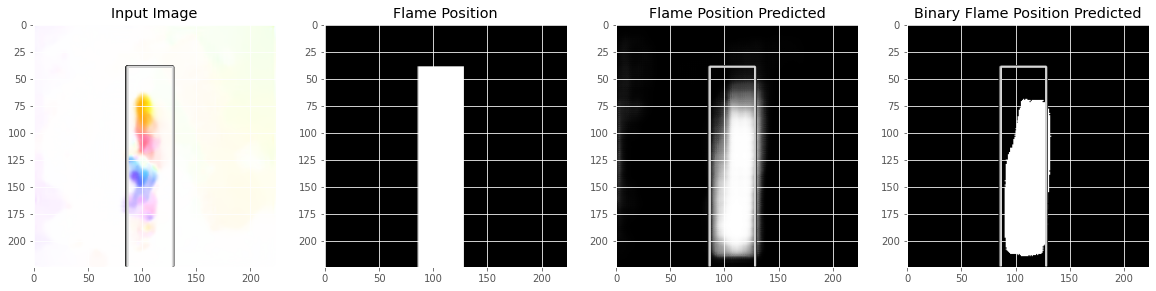

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

### Predictions on **test** set

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'interpolation'
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'interpolation'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'interpolation'


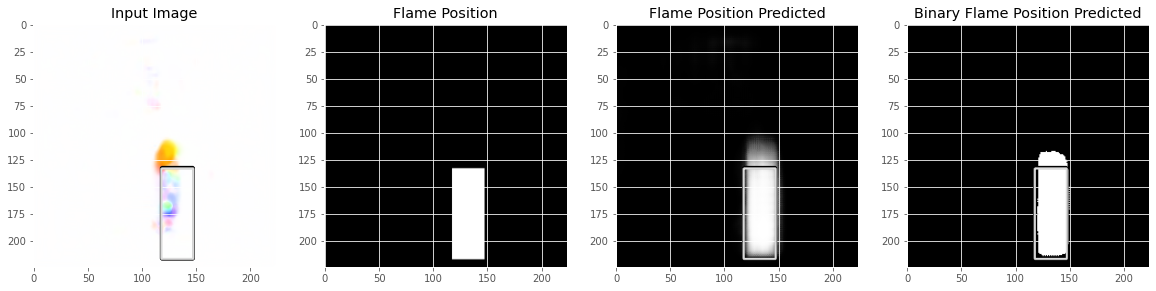

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

---

In [ ]:
y_pred = model.predict(X, verbose=1)

117/117 [==============================] - 493s 4s/step


In [ ]:
y_pred_t = (y_pred > 0.5).astype(np.uint8)

In [ ]:
class_pred=[]
cnt=0
for i in range(len(y_pred)):
  if y_pred[i].max()<=0.5 :
    class_pred.append(0)
    cnt=cnt+1
  else:
    class_pred.append(1)

print (' <no fire> predected : ',cnt)

 <no fire> predected :  210


In [ ]:
len(y_pred)

3735

---
# <center> Metrics for Evaluation 
---

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
gt=class_true
pr=class_pred

#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

Confusion matrix:
 [[   4    5]
 [ 206 3520]]
Accuracy: 0.943507
Precision: 0.998582
Recall: 0.944713
F1 score: 0.970901


In [ ]:
print(pr)
print(gt)

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [ ]:
for i in range(len(pr)):
  if pr[i]==1 and gt[i]==0:
    print (i)

816
2336
2682
3396
3665


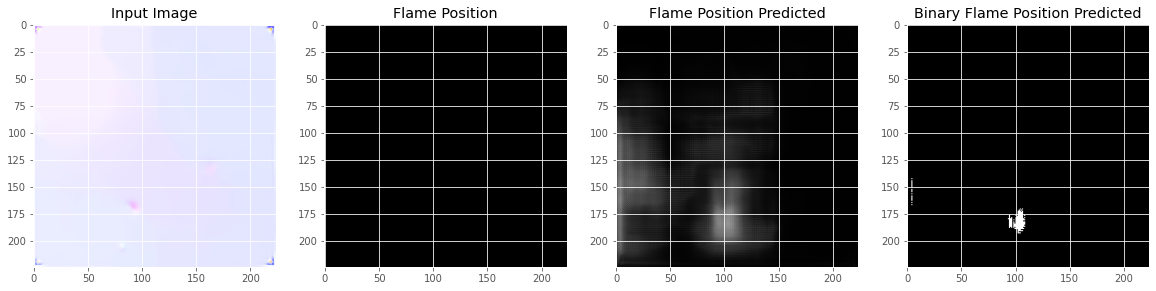

In [ ]:
plot_sample(X, y, y_pred, y_pred_t, ix=3665)

---